# **BeDOZa Protocol With Oblivious Transfer vs Not Privacy-Preserving Computation**




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
p = 107  # Prime modulus
q = 53   # Order of the cyclic group
g = 2  # Generator

Global auxiliary variables:

In [ ]:
number_of_curr_MULT = 0
d_array = []
e_array = []

## The definition of the function:

In [ ]:
n = 2

In [ ]:
inequality = 1

In [ ]:
number = 4

In [ ]:
list_of_mults = [(False, 0, 2), (False, 1, 3)]

## OT's Class:

In [ ]:
class OT:
  def __init__(self, p, q, g):
    self.p = p  # Prime modulus
    self.q = q  # Order of the cyclic group
    self.g = g  # Generator

    self.curr_r = np.random.randint(0, p - 1)
    self.output = 0
    self.r = 0
    self.sum_r = 0

    self.pk0 = -1
    self.pk1 = -1

  def Gen(self):
    # sk = random.randint(0, self.q - 1)  # Secret key
    sk = np.random.randint(0, self.q)  # Secret key
    pk = pow(self.g, sk, self.p)  # Public key
    return pk, sk

  def Enc(self, m, pk):
    r = np.random.randint(0, self.q)  # Random value
    c1 = pow(self.g, r, self.p)
    c2 = (m * pow(pk, r, self.p)) % self.p
    return c1, c2

  def Dec(self, c, sk):
    c1, c2 = c
    m = (c2 * pow(c1, -sk, self.p)) % self.p
    return m

  def OGen(self, r):
    s = np.random.randint(0, self.p)  # Random value
    h = pow(s, 2, self.p)
    return h

## MAC's Class:

In [ ]:
class MAC:
  def __init__(self, x, key, tag):
    self.value = x
    self.key = key
    self.tag = tag

## Node of Circuit's Class
The Node class represents a node in a circuit, which can have two input parents and an operator (op) that defines the operation to be performed on the parents' values. A Circuit is then made up of a collection of Node instances that are interconnected to form a larger computational graph.

In [ ]:
class Node:
  def __init__(self, op, constant, parent1, parent2):
    self.value = None
    self.constant = constant        # contains "False" if the operator is applied to x,y and "True" if the operator is applied to x,c
    self.op = op                    # contains "+" or "*"
    self.parent1 = parent1
    self.parent2 = parent2
    self.sons = []
    self.output = False             # contains "True" if this is leaf in the circuit and "False" otherwise
    self.tag = -1
    self.key = -1

## Circuit's Class:

In [ ]:
class Circuit:
  def __init__(self, n, input, MULTS, number, inequality, p):
    self.number_of_mult_gates = 0
    self.n = n
    self.input = input
    self.MULTS = MULTS
    self.p = p
    self.number = number
    self.inequality = inequality
    self.results_of_greater_than = []

  def Mul(self, parent1, parent2, constant):
    self.number_of_mult_gates += 1
    node_mul = Node("*", constant, parent1, parent2)
    parent1.sons.append(node_mul)
    if constant == False:
      parent2.sons.append(node_mul)
    return node_mul


  def Add(self, parent1, parent2, constant):
    node_add = Node("+", constant, parent1, parent2)
    parent1.sons.append(node_add)
    if constant == False:
      parent2.sons.append(node_add)
    return node_add

  def while_of_visited(self, visited, op, const_flag):
    new_visited = []
    while len(visited) > 1:
      for i in range(0, len(visited), 2):
        if (i + 1) >= len(visited):
          new_visited.append(visited[i])
        else:
          new_visited.append(op(visited[i], visited[i + 1], const_flag))
      visited = new_visited.copy()
      new_visited = []
    return visited[0]

  def GreaterThan(self, parent):
    results_of_power = []

    for i in range(self.number):
      node = self.Add(parent1=parent, parent2=np.negative(i), constant=True)
      results_of_power.append(node)
      for j in range(self.p - 2):
        node_son = self.Mul(parent1=results_of_power[i], parent2=node, constant=False)
        results_of_power[i] = node_son

    if self.inequality == 3 or self.inequality == 0:                                        # the operator is <= or >
      i = self.number
      node = self.Add(parent1=parent, parent2=np.negative(i), constant=True)
      results_of_power.append(node)
      for j in range(self.p - 2):
        node_son = self.Mul(parent1=results_of_power[i], parent2=node, constant=False)
        results_of_power[i] = node_son

    result = self.while_of_visited(results_of_power, self.Mul, False)
    return result

  def Not(self, parent):
    node = self.Add(parent, -1, True)
    node_not = self.Mul(node, -1, True)
    return node_not

  def sum(self, parent1, parent2, constant):
    sum = self.Add(parent1, parent2, False)
    self.results_of_greater_than.append(self.GreaterThan(sum))
    return sum

  def GenerateCircuit(self):
    self.number_of_mult_gates = 0
    nodes = np.zeros((2 * self.n), dtype=object)
    visited = []
    new_visited = []
    results_of_mul = []
    results_of_greater_than = []
    results_of_not = []
    for i in range(len(self.input)):
        nodes[i] = Node(None, False, None, None)
        nodes[i].value = self.input[i]
    for mult in self.MULTS:
        constant = mult[0]
        parent1 = nodes[mult[1]]
        if constant == False:
            parent2 = nodes[mult[2]]
        else:
            parent2 = mult[2]
        mul = self.Mul(parent1, parent2, constant)
        results_of_mul.append(mul)
    for mul in results_of_mul:
        results_of_greater_than.append(self.GreaterThan(mul))

    self.results_of_greater_than = []
    result = self.while_of_visited(results_of_mul, self.sum, False)
    results_of_greater_than = self.results_of_greater_than
    results_of_greater_than.append(self.GreaterThan(result))

    for node in results_of_greater_than:
      results_of_not.append(self.Not(node))

    result = self.while_of_visited(results_of_not, self.Mul, False)
    if self.inequality == 1 or self.inequality == 3:                            # the operator is >= or >
      result = self.Not(result)
    result.output = True
    return nodes, self.number_of_mult_gates

## Alice's Class:

In [ ]:
class Alice:
    """
    Attributes:
      - param circuit: an object of Circuit that represents an arithmetic circuit.
      - param number_of_mult_gates: number of mult gates in the circuit
      - param x: Alice's input.
      - param alphaA: a random value from {0,p-1} that represents the alpha of Alice's keys.
      - param keys_array: A temporary list that contains all the keys of a certain variable.
      - param tags_array: A temporary list that contains all the tags of a certain variable.
      - param input: A temporary parameter that saves the Receiver's input, 0 or 1 (for OT-2).
      - param sk: A temporary parameter that saves the Receiver's secret key (for OT).
      - param u_A: an array of random values from {0,p-1}.
      - param v_A: an array of random values from {0,p-1}.
      - param w_A: an array of random values from {0,p-1}.
      - param r_A: an array of random values from {0,p-1}.
      - param mults: a temporary array that holds the indexes of mult gates in a specific layer.
      - param z_A: an array that holds the leaf node in Alice's circuit.
      - param z_B: an array that Bob sends to Alice and holds the leaf node in Bob's circuit.
      - param visited: a list that contains all the nodes in the next layer.
      - param occurred_nodes: a list that contains all the nodes we have already calculated their value.
    """

    def __init__(self, circuit, x):
      self.x = x
      self.circuit, self.number_of_mult_gates = circuit.GenerateCircuit()

      self.r_A = [np.random.randint(0, p) for _ in range(2 * n)]
      self.alphaA = np.random.randint(0, p)
      self.keys_array = []
      self.tags_array = []
      self.input = -1

      self.sk = -1

      self.u_A = [np.random.randint(0, p) for _ in range(self.number_of_mult_gates)]
      self.v_A = [np.random.randint(0, p) for _ in range(self.number_of_mult_gates)]
      self.w_A = []

      self.mults = []
      self.visited = []
      self.occurred_nodes = []

      self.z_A = None
      self.z_B = None

    def GenerateKeysAndTagsArray(self, len):
      """
      Generate the key list using Alice's alpha and empty the tag list.
      Attributes:
        - param len: the required number of keys.
      """
      self.keys_array = [(self.alphaA, np.random.randint(0, p)) for _ in range(len)]
      self.tags_array = []
      return

    def CreateMACs(self, inputA, keys_array, tags_array):
      """
      Combine 3 lists of values, keys and tags into one list of MACs.
      Attributes:
        - param inputA: the required number of keys.
        - param keys_array: a key list.
        - param tags_array: a tag list.
      Returns:
        - macs_arrayA: the MACs list.
      """
      macs_arrayA = np.zeros(len(inputA), dtype=object)
      for i in range(len(inputA)):
        macs_arrayA[i] = MAC(inputA[i], keys_array[i], tags_array[i])
      return macs_arrayA

    
    # Functions for generating tags:

    def ReceiverTags(self, i, receiver_choice, ot):
      """
      Receiver's part 1.
      Attributes:
        - param i: an index in {0,p-1} for OT-n when n = p.
        - param receiver_choice: the receiver's choice bit.
        - param ot: an object of type 1-out-of-n Oblivious Transfer where n = p.
      """
      ot.pk0, self.sk = ot.Gen()  # Generate public-private key pair for choice 0
      ot.pk1 = ot.OGen(np.random.randint(0, p))  # Generate modified public key for choice 1
      self.input = 1 if i == receiver_choice else 0
      return

    def ReceiverOutputTags(self, c0, c1, ot):
      """
      Receiver's part 2.
      Attributes:
        - param c0: Enc(m0, pk0).
        - param c1: Enc(m1, pk1).
        - param ot: an object of type 1-out-of-n Oblivious Transfer where n = p.
      """
      chosen_ciphertext = c1 if self.input == 0 else c0
      curr_output = ot.Dec(chosen_ciphertext, self.sk)
      if self.input != 1:
        ot.sum_r = (ot.sum_r + curr_output) % p
        ot.curr_r = curr_output
      else:
        self.tags_array.append((curr_output - ot.sum_r) % p)

    def SenderTags(self, i, index, ot):
      """
      Sender's function.
      Attributes:
        - param i: an index in {0,p-1} for OT-n when n = p.
        - param index: an index in value list. 
        - param ot: an object of type 1-out-of-n Oblivious Transfer where n = p.
      Returns:
        - c0: Enc(m0, pk0).
        - c1: Enc(m1, pk1).
      """
      if i != 0:
        ot.r = (ot.r + ot.curr_r) % p
      m_i = self.keys_array[index][0] * i + self.keys_array[index][1]
      m0 = (m_i + ot.r) % p
      m1 = ot.curr_r

      c0 = ot.Enc(m0, ot.pk0)
      c1 = ot.Enc(m1, ot.pk1)
      return c0, c1

    # Functions for generating w_A:

    def ReceiverW_A(self, i, index_in_mults, ot):
      """
      Receiver's part 1.
      Attributes:
        - param i: an index in {0,p^2-1} for OT-n when n = p^2.
        - param index_in_mults: an index in u, v and w lists. 
        - param ot: an object of type 1-out-of-n Oblivious Transfer where n = p^2.
      """
      ot.pk0, self.sk = ot.Gen()  # Generate public-private key pair for choice 0
      ot.pk1 = ot.OGen(np.random.randint(0, p))  # Generate modified public key for choice 1
      receiver_choice = p * self.u_A[index_in_mults] + self.v_A[index_in_mults] # Receiver's choice bit
      self.input = 1 if i == receiver_choice else 0
      return

    def ReceiverOutputW_A(self, c0, c1, ot):
      """
      Receiver's part 2.
      Attributes:
        - param c0: Enc(m0, pk0).
        - param c1: Enc(m1, pk1).
        - param ot: an object of type 1-out-of-n Oblivious Transfer where n = p^2.
      """
      chosen_ciphertext = c1 if self.input == 0 else c0
      curr_output = ot.Dec(chosen_ciphertext, self.sk)
      if self.input != 1:
        ot.sum_r = (ot.sum_r + curr_output) % p
        ot.curr_r = curr_output
      else:
        self.w_A.append((curr_output - ot.sum_r) % p)
    

    def OpenTo(self, node_x_A, node_x_B):
      """
      Attributes:
        - param node_x_A: a node of x_A.
        - param node_x_B: a node of x_B.
      Returns:
        - x: returs OpenTo(x_A, x_B) if Verify(x_B, k_A, t_B) = ACCEPT and False otherwise.
      """
      if type(node_x_A) is np.ndarray and type(node_x_B) is np.ndarray:
        x = np.zeros((len(node_x_A)), dtype=int)
        for i in range(len(node_x_A)):
          x[i] = np.add(node_x_A[i].value, node_x_B[i].value) % p
          if not self.Verify(node_x_B[i].value, node_x_A[i].key, node_x_B[i].tag):
            return False
      else:
        x = np.add(node_x_A.value, node_x_B.value) % p
        if not self.Verify(node_x_B.value, node_x_A.key, node_x_B.tag):
          return False
      return x

    def ReceiveR_BAndSendD(self, r_B):
      """
      Attributes:
        - param r_B: an array of MACs from {0,p-1}.
      Returns:
        - d: an array such that d[i] = x[i] - r[i].
      """
      r = self.OpenTo(self.r_A[:n], r_B)

      d = np.zeros((n), dtype=int)
      for i in range(0, n):
        d[i] = self.x[i] - r[i]
        self.circuit[i].value, self.circuit[i].key, self.circuit[i].tag = self.ADD_with_const(self.r_A[i], d[i])
      return d

    def SendR_A(self):
      """
      Returns:
        - r_A: an array of MACs from {0,p-1}.
      """
      return self.r_A[n:]

    def ReceiveD(self, d):
      """
      Attributes:
        - param d: such that d[i] = y[i] - r[i].
      """
      for i in range(n, 2*n):
        self.circuit[i].value, self.circuit[i].key, self.circuit[i].tag = self.ADD_with_const(self.r_A[i], d[i - n])

      for i in range(len(self.circuit)):
        for son in self.circuit[i].sons:
          self.visited.append(son)
        self.occurred_nodes.append(self.circuit[i])
      return

    def ADD(self, node_x, node_y):
      """
      Attributes:
        - param node_x: a node of x.
        - param node_y: a node of y.
      Returns:
        - z_A: x_A + y_A.
        - k_Az: (alpha_x, beta_x + beta_y).
        - t_Az: t_x + t_y.
      """
      key_x = node_x.key
      key_y = node_y.key

      z_A = (node_x.value + node_y.value) % p
      k_Az = (key_x[0] % p, (key_x[1] + key_y[1]) % p)
      t_Az = (node_x.tag + node_y.tag) % p
      return z_A, k_Az, t_Az

    def ADD_with_const(self, node_x, c):
      """
      Attributes:
        - param node_x: a node of x.
        - param c: a value of c.
      Returns:
        - z_A: x_A + c.
        - k_Az: (alpha_x, beta_x).
        - t_Az: t_x.
      """
      key_x = node_x.key

      z_A = (node_x.value + c) % p
      k_Az = (key_x[0] % p, key_x[1] % p)
      t_Az = node_x.tag % p
      return z_A, k_Az, t_Az

    def MULT(self, node_x, node_y, u_A, v_A, w_A, d, e):
      """
      Attributes:
        - param node_x: a node of x.
        - param node_y: a node of y.
        - u_A: a MAC.
        - v_A: a MAC.
        - w_A: a MAC.
        - d: OpenTo(d_A, d_B).
        - e: OpenTo(e_A, e_B).
      Returns:
        - z_A: x_A * y_A.
        - k_Az: (alpha_x, beta_new).
        - t_Az: t_new.
      """
      key_x = node_x.key
      key_y = node_y.key

      z_mul1, k_mul1, t_mul1 = self.MULT_with_const(u_A, e)
      z_mul2, k_mul2, t_mul2 = self.MULT_with_const(v_A, d)

      mac1 = MAC(z_mul1, k_mul1, t_mul1)
      mac2 = MAC(z_mul2, k_mul2, t_mul2)

      z_add1, k_add1, t_add1 = self.ADD(mac1, mac2)
      mac3 = MAC(z_add1, k_add1, t_add1)

      z_add2, k_add2, t_add2 = self.ADD(w_A, mac3)
      mac4 = MAC(z_add2, k_add2, t_add2)

      z_A, k_Az, t_Az = self.ADD_with_const(mac4, e*d)
      return z_A, k_Az, t_Az

    def MULT_with_const(self, node_x, c):
      """
      Attributes:
        - param node_x: a node of x.
        - param c: a value of c.
      Returns:
        - z_A: x_A * c.
        - k_Az: (alpha_x, beta_x * c).
        - t_Az: t_x * c.
      """
      key_x = node_x.key

      z_A = (node_x.value * c) % p
      k_Az = (key_x[0] % p, (key_x[1] * c) % p)
      t_Az = (node_x.tag * c) % p
      return z_A, k_Az, t_Az

    def Receive(self, z_B):
        """
        Attributes:
          param z_B: an array of the leaf in Bob's circuit.
        """
        global d_array, e_array

        self.z_B = z_B

        for mult_node in self.mults:
            node_x_A = mult_node.parent1
            node_y_A = mult_node.parent2
            number_of_current_MULT = mult_node.value
            mult_node.value, mult_node.key, mult_node.tag = self.MULT(node_x_A, node_y_A, self.u_A[number_of_current_MULT], self.v_A[number_of_current_MULT], self.w_A[number_of_current_MULT], d_array[0], e_array[0])
            del d_array[0]
            del e_array[0]
        d_array = []
        e_array = []
        self.mults.clear()

    def Send(self):
      """
      Returns:
        - MULTS: an array that holds the indexes of mult gates in a specific layer.
      """
      global number_of_curr_MULT

      MULTS = []

      new_visited = []
      if len(self.visited) == 1:
        self.z_A = self.visited[0]

      for node in self.visited:
        node_x_A = node.parent1
        if node.constant == False:
          node_y_A = node.parent2
        else:
          c = node.parent2

        if node.value is None:
          if node.op == "+" and node.constant:
            node.value, node.key, node.tag = self.ADD_with_const(node_x_A, c)

          if node.op == "+" and not node.constant:
            node.value, node.key, node.tag = self.ADD(node_x_A, node_y_A)

          if node.op == "*" and node.constant:
            node.value, node.key, node.tag = self.MULT_with_const(node_x_A, c)

          if node.op == "*" and not node.constant:
            self.mults.append(node)
            d_A = np.subtract(node_x_A.value, self.u_A[number_of_curr_MULT].value) % p
            e_A = np.subtract(node_y_A.value, self.v_A[number_of_curr_MULT].value) % p
            node.value = number_of_curr_MULT
            MULTS.append([d_A, e_A, number_of_curr_MULT])
            number_of_curr_MULT += 1
              
          self.occurred_nodes.append(node)
          if len(node.sons) != 0:
            for son in node.sons:
              if son.parent1 in self.occurred_nodes and (son.constant or son.parent2 in self.occurred_nodes):
                new_visited.append(son)

      self.visited = new_visited.copy()
      new_visited.clear()
      return MULTS

    def hasOutput(self):
      """
      Returns:
        - True/False: a Boolean value indicating whether Alice has input.
      """
      if self.z_B is not None:
        return True
      return False

    def Output(self):
      """
      Returns:
        - z: Alice's output.
      """
      z = self.OpenTo(self.z_A, self.z_B[0])
      return z

    def Verify(self, x, k, t):
      """
      Attributes:
        - param x: a value of x.
        - param k: a tuple of key.
        - param t: a tag.
      Returns:
        - True or False: True if Ver(x,k,t) = ACCEPT and False if Ver(x,k,t) = ABORT.
      """
      if (k[0] * x + k[1]) % p == t:
        return True
      else:
        return False

## Bob's Class:

In [ ]:
class Bob:
    """
    Attributes:
      - param circuit: an object of Circuit that represents an arithmetic circuit.
      - param number_of_mult_gates: number of mult gates in the circuit
      - param y: Bobs's input.
      - param alphaB: a random value from {0,p-1} that represents the alpha of Bob's keys.
      - param keys_array: A temporary list that contains all the keys of a certain variable.
      - param tags_array: A temporary list that contains all the tags of a certain variable.
      - param input: A temporary parameter that saves the Receiver's input, 0 or 1 (for OT-2).
      - param sk: A temporary parameter that saves the Receiver's secret key (for OT).
      - param u_B: an array of random values from {0,p-1}.
      - param v_B: an array of random values from {0,p-1}.
      - param w_B: an array of random values from {0,p-1}.
      - param r_B: an array of random values from {0,p-1}.
      - param z_B: an array that Bob sends to Alice and holds the leaf node in Bob's circuit.
      - param visited: a list that contains all the nodes in the next layer.
      - param occurred_nodes: a list that contains all the nodes we have already calculated their value.
    """

    def __init__(self, circuit, y):
      self.y = y
      self.circuit, self.number_of_mult_gates = circuit.GenerateCircuit()

      self.r_B = [np.random.randint(0, p) for _ in range(2 * n)]
      self.alphaB = np.random.randint(0, p)
      self.keys_array = []
      self.tags_array = []
      self.input = -1

      self.sk = -1

      self.u_B = [np.random.randint(0, p) for _ in range(self.number_of_mult_gates)]
      self.v_B = [np.random.randint(0, p) for _ in range(self.number_of_mult_gates)]
      self.w_B = [np.random.randint(0, p) for _ in range(self.number_of_mult_gates)]

      self.visited = []
      self.occurred_nodes = []

      self.z_B = None

    def GenerateKeysAndTagsArray(self, len):
      """
      Generate the key list using Bob's alpha and empty the tag list.
      Attributes:
        - param len: the required number of keys.
      """
      self.keys_array = [(self.alphaB, np.random.randint(0, p)) for _ in range(len)]
      self.tags_array = []
      return

    def CreateMACs(self, inputB, keys_array, tags_array):
      """
      Combine 3 lists of values, keys and tags into one list of MACs.
      Attributes:
        - param inputB: the required number of keys.
        - param keys_array: a key list.
        - param tags_array: a tag list.
      Returns:
        - macs_arrayB: the MACs list.
      """
      macs_arrayB = np.zeros(len(inputB), dtype=object)
      for i in range(len(inputB)):
        macs_arrayB[i] = MAC(inputB[i], keys_array[i], tags_array[i])
      return macs_arrayB
    

    # Functions for generating tags:
    
    def SenderTags(self, i, index, ot):
      """
      Sender's function.
      Attributes:
        - param i: an index in {0,p-1} for OT-n when n = p.
        - param index: an index in value list. 
        - param ot: an object of type 1-out-of-n Oblivious Transfer where n = p.
      Returns:
        - c0: Enc(m0, pk0).
        - c1: Enc(m1, pk1).
      """
      if i != 0:
        ot.r = (ot.r + ot.curr_r) % p
      m_i = self.keys_array[index][0] * i + self.keys_array[index][1]
      m0 = (m_i + ot.r) % p
      m1 = ot.curr_r

      c0 = ot.Enc(m0, ot.pk0)
      c1 = ot.Enc(m1, ot.pk1)
      return c0, c1

    def ReceiverTags(self, i, receiver_choice, ot):
      """
      Receiver's part 1.
      Attributes:
        - param i: an index in {0,p-1} for OT-n when n = p.
        - param receiver_choice: the receiver's choice bit.
        - param ot: an object of type 1-out-of-n Oblivious Transfer where n = p.
      """
      ot.pk0, self.sk = ot.Gen()  # Generate public-private key pair for choice 0
      ot.pk1 = ot.OGen(np.random.randint(0, p))  # Generate modified public key for choice 1
      self.input = 1 if i == receiver_choice else 0
      return

    def ReceiverOutputTags(self, c0, c1, ot):
      """
      Receiver's part 2.
      Attributes:
        - param c0: Enc(m0, pk0).
        - param c1: Enc(m1, pk1).
        - param ot: an object of type 1-out-of-n Oblivious Transfer where n = p.
      """
      chosen_ciphertext = c1 if self.input == 0 else c0
      curr_output = ot.Dec(chosen_ciphertext, self.sk)
      if self.input != 1:
        ot.sum_r = (ot.sum_r + curr_output) % p
        ot.curr_r = curr_output
      else:
        self.tags_array.append((curr_output - ot.sum_r) % p)

    # Function for generating w_A:

    def SenderW_A(self, i, index_in_mults, ot):
      """
      Sender's function.
      Attributes:
        - param i: an index in {0,p^2-1} for OT-n when n = p^2.
        - param index_in_mults: an index in u, v and w lists. 
        - param ot: an object of type 1-out-of-n Oblivious Transfer where n = p^2.
      Returns:
        - c0: Enc(m0, pk0).
        - c1: Enc(m1, pk1).
      """
      if i != 0:
        ot.r = (ot.r + ot.curr_r) % p
      m_i = (((i // p + self.u_B[index_in_mults]) % p) * ((i % p + self.v_B[index_in_mults]) % p) - self.w_B[index_in_mults]) % p
      m0 = (m_i + ot.r) % p
      m1 = ot.curr_r

      c0 = ot.Enc(m0, ot.pk0)
      c1 = ot.Enc(m1, ot.pk1)
      return c0, c1


    def OpenTo(self, node_x_A, node_x_B):
      """
      Attributes:
        - param node_x_A: a node of x_A.
        - param node_x_B: a node of x_B.
      Returns:
        - x: returs OpenTo(x_A, x_B) if Verify(x_A, k_B, t_A) = ACCEPT and False otherwise.
      """
      if type(node_x_A) is np.ndarray and type(node_x_B) is np.ndarray:
        x = np.zeros((len(node_x_A)), dtype=int)
        for i in range(len(node_x_A)):
          x[i] = np.add(node_x_A[i].value, node_x_B[i].value) % p
          if not self.Verify(node_x_A[i].value, node_x_B[i].key, node_x_A[i].tag):
            return False
      else:
        x = np.add(node_x_A.value, node_x_B.value) % p
        if not self.Verify(node_x_A.value, node_x_B.key, node_x_A.tag):
          return False
      return x

    def SendR_B(self):
      """
      Returns:
        - r_B: an array of MACs from {0,p-1}.
      """
      return self.r_B[:n]

    def ReceiveD(self, d):
      """
      Attributes:
        - param d: such that d[i] = x[i] - r[i].
      """
      for i in range(0,n):
        self.circuit[i].value, self.circuit[i].key, self.circuit[i].tag = self.ADD_with_const(self.r_B[i], d[i])

    def ReceiveR_AAndSendD(self, r_A):
      """
      Attributes:
        - param r_A: an array of MACs from {0,p-1}.
      Returns:
        - d: an array such that d[i] = y[i] - r[i].
      """
      r = self.OpenTo(r_A, self.r_B[n:])

      d = np.zeros((n), dtype=int)
      for i in range(0, n):
        d[i] = self.y[i] - r[i]
        self.circuit[i + n].value, self.circuit[i + n].key, self.circuit[i + n].tag = self.ADD_with_const(self.r_B[i + n], d[i])

      for i in range(len(self.circuit)):
        for son in self.circuit[i].sons:
          self.visited.append(son)
        self.occurred_nodes.append(self.circuit[i])
      return d

    def ADD(self, node_x, node_y):
      """
      Attributes:
        - param node_x: a node of x.
        - param node_y: a node of y.
      Returns:
        - z_B: x_B + y_B.
        - k_Bz: (alpha_x, beta_x + beta_y).
        - t_Bz: t_x + t_y.
      """
      key_x = node_x.key
      key_y = node_y.key

      z_B = (node_x.value + node_y.value) % p
      k_Bz = (key_x[0] % p, (key_x[1] + key_y[1]) % p)
      t_Bz = (node_x.tag + node_y.tag) % p
      return z_B, k_Bz, t_Bz

    def ADD_with_const(self, node_x, c):
      """
      Attributes:
        - param node_x: a node of x.
        - param c: a value of c.
      Returns:
        - z_B: x_B + c.
        - k_Bz: (alpha_x, beta_x - c * alpha_x).
        - t_Bz: t_x.
      """
      key_x = node_x.key

      z_B = (node_x.value) % p
      k_Bz = (key_x[0] % p, (key_x[1] - c * key_x[0]) % p)
      t_Bz = node_x.tag % p
      return z_B, k_Bz, t_Bz

    def MULT(self, node_x, node_y, u_B, v_B, w_B, d, e):
      """
      Attributes:
        - param node_x: a node of x.
        - param node_y: a node of y.
        - u_B: a MAC.
        - v_B: a MAC.
        - w_B: a MAC.
        - d: OpenTo(d_A, d_B).
        - e: OpenTo(e_A, e_B).
      Returns:
        - z_B: x_B * y_B.
        - k_Bz: (alpha_x, beta_new).
        - t_Bz: t_new.
      """
      key_x = node_x.key
      key_y = node_y.key

      z_mul1, k_mul1, t_mul1 = self.MULT_with_const(u_B, e)
      z_mul2, k_mul2, t_mul2 = self.MULT_with_const(v_B, d)

      mac1 = MAC(z_mul1, k_mul1, t_mul1)
      mac2 = MAC(z_mul2, k_mul2, t_mul2)

      z_add1, k_add1, t_add1 = self.ADD(mac1, mac2)
      mac3 = MAC(z_add1, k_add1, t_add1)

      z_add2, k_add2, t_add2 = self.ADD(w_B, mac3)
      mac4 = MAC(z_add2, k_add2, t_add2)

      z_B, k_Bz, t_Bz = self.ADD_with_const(mac4, e*d)
      return z_B, k_Bz, t_Bz

    def MULT_with_const(self, node_x, c):
      """
      Attributes:
        - param node_x: a node of x.
        - param c: a value of c.
      Returns:
        - z_B: x_B * c.
        - k_Bz: (alpha_x, beta_x * c).
        - t_Bz: t_x * c.
      """
      key_x = node_x.key

      z_B = (node_x.value * c) % p
      k_Bz = (key_x[0] % p, (key_x[1] * c) % p)
      t_Bz = (node_x.tag * c) % p
      return z_B, k_Bz, t_Bz

    def Receive(self, MULTS):
      """
      Attributes:
        - param MULTS: an array that holds the indexes of mult gates in a specific layer.
      """
      global d_array, e_array

      new_visited = []
      for node in self.visited:
        node_x_B = node.parent1
        if node.constant == False:
          node_y_B = node.parent2
        else:
          c = node.parent2
        if node.value is None:
          if node.op == "+" and node.constant:
            node.value, node.key, node.tag = self.ADD_with_const(node_x_B, c)
          if node.op == "+" and not node.constant:
            node.value, node.key, node.tag = self.ADD(node_x_B, node_y_B)
          if node.op == "*" and node.constant:
            node.value, node.key, node.tag = self.MULT_with_const(node_x_B, c)
          if node.op == "*" and not node.constant:
            number_of_current_MULT = MULTS[0][2]
            d_A = MULTS[0][0]
            d_B = np.subtract(node_x_B.value, self.u_B[number_of_current_MULT].value) % p
            d_array.append(d_A + d_B)

            e_A = MULTS[0][1]
            e_B = np.subtract(node_y_B.value, self.v_B[number_of_current_MULT].value) % p
            e_array.append(e_A + e_B)

            del MULTS[0]

            node.value, node.key, node.tag = self.MULT(node_x_B, node_y_B, self.u_B[number_of_current_MULT], self.v_B[number_of_current_MULT], self.w_B[number_of_current_MULT], d_array[-1], e_array[-1])

          self.occurred_nodes.append(node)
          if len(node.sons) != 0:
            for son in node.sons:
              if son.parent1 in self.occurred_nodes and (son.constant == True or son.parent2 in self.occurred_nodes):
                new_visited.append(son)
            self.z_B = new_visited.copy()

      self.visited = new_visited.copy()
      new_visited.clear()

    def Send(self):
      """
        Returns:
          - z_B: an array of the leaf in Bob's circuit.
      """
      if len(self.visited) > 0:
        return None
      else:
        return self.z_B

    def Verify(self, x, k, t):
      """
      Attributes:
        - param x: a value of x.
        - param k: a tuple of key.
        - param t: a tag.
      Returns:
        - True or False: True if Ver(x,k,t) = ACCEPT and False if Ver(x,k,t) = ABORT.
      """
      if (k[0] * x + k[1]) % p == t:
        return True
      else:
        return False

**Plot function:** 

In [ ]:
def plot(pp_time, npp_time):
  plt.figure(figsize=(20, 5))
  plt.scatter(range(len(pp_time)),pp_time, label='privacy-preserving', s=50, color='#00FF00', alpha=0.5)
  plt.scatter(range(len(npp_time)),npp_time, label='not privacy-preserving', s=10, color='#FF3131', alpha=1)
  plt.xlabel('input (x_1,x_2,a_1,a_2)')
  plt.ylabel('time per execution')
  plt.legend()
  
  plt.show()

**All possible inputs:**

In [ ]:
a_vec = [[0,0],[0,1],[0,2],[0,3],[1,0],[1,1],[1,2],[1,3],[2,0],[2,1],[2,2],[2,3],[3,0],[3,1],[3,2],[3,3]]
x_vec = [[0,0],[0,1],[0,2],[0,3],[1,0],[1,1],[1,2],[1,3],[2,0],[2,1],[2,2],[2,3],[3,0],[3,1],[3,2],[3,3]]

## **privacy-preserving computation:**

In [ ]:
pp_z = np.zeros((n**4)*(n**4), dtype=int)
pp_time = np.zeros((n**4)*(n**4), dtype=float)
idx = 0
for i in range(len(x_vec)):
  for j in range(len(a_vec)):
    pp_time[idx] = time.time()
    number_of_curr_MULT = 0

    input = np.zeros((2*n), dtype=int)
    circuit = Circuit(n, input, list_of_mults, number, inequality, p)
    alice = Alice(circuit=circuit, x=x_vec[i])
    bob = Bob(circuit=circuit, y=a_vec[j])

    alice.GenerateKeysAndTagsArray(2 * n)
    bob.GenerateKeysAndTagsArray(2 * n)
    for index in range(2 * n):
      otA = OT(p, q, g)
      otB = OT(p, q, g)
      for i1 in range(p):
        alice.ReceiverTags(i1, alice.r_A[index], otA)
        c0, c1 = bob.SenderTags(i1, index, otA)
        alice.ReceiverOutputTags(c0, c1, otA)

        bob.ReceiverTags(i1, bob.r_B[index], otB)
        c0, c1 = alice.SenderTags(i1, index, otB)
        bob.ReceiverOutputTags(c0, c1, otB)
    alice.r_A = alice.CreateMACs(alice.r_A, alice.keys_array, alice.tags_array)
    bob.r_B = bob.CreateMACs(bob.r_B, bob.keys_array, bob.tags_array)

    for index in range(alice.number_of_mult_gates):
      otA = OT(p, q, g)
      for i1 in range(pow(p, 2)):
        alice.ReceiverW_A(i1, index, otA)
        c0, c1 = bob.SenderW_A(i1, index, otA)
        alice.ReceiverOutputW_A(c0, c1, otA)
    
    alice.GenerateKeysAndTagsArray(alice.number_of_mult_gates)
    bob.GenerateKeysAndTagsArray(bob.number_of_mult_gates)

    for index in range(alice.number_of_mult_gates):
      otA = OT(p, q, g)
      otB = OT(p, q, g)
      for i1 in range(p):
        alice.ReceiverTags(i1, alice.u_A[index], otA)
        c0, c1 = bob.SenderTags(i1, index, otA)
        alice.ReceiverOutputTags(c0, c1, otA)

        bob.ReceiverTags(i1, bob.u_B[index], otB)
        c0, c1 = alice.SenderTags(i1, index, otB)
        bob.ReceiverOutputTags(c0, c1, otB)
    alice.u_A = alice.CreateMACs(alice.u_A, alice.keys_array, alice.tags_array)
    bob.u_B = bob.CreateMACs(bob.u_B, bob.keys_array, bob.tags_array)

    alice.GenerateKeysAndTagsArray(alice.number_of_mult_gates)
    bob.GenerateKeysAndTagsArray(bob.number_of_mult_gates)

    for index in range(alice.number_of_mult_gates):
      otA = OT(p, q, g)
      otB = OT(p, q, g)
      for i1 in range(p):
        alice.ReceiverTags(i1, alice.v_A[index], otA)
        c0, c1 = bob.SenderTags(i1, index, otA)
        alice.ReceiverOutputTags(c0, c1, otA)

        bob.ReceiverTags(i1, bob.v_B[index], otB)
        c0, c1 = alice.SenderTags(i1, index, otB)
        bob.ReceiverOutputTags(c0, c1, otB)
    alice.v_A = alice.CreateMACs(alice.v_A, alice.keys_array, alice.tags_array)
    bob.v_B = bob.CreateMACs(bob.v_B, bob.keys_array, bob.tags_array)

    alice.GenerateKeysAndTagsArray(alice.number_of_mult_gates)
    bob.GenerateKeysAndTagsArray(bob.number_of_mult_gates)

    for index in range(alice.number_of_mult_gates):
      otA = OT(p, q, g)
      otB = OT(p, q, g)
      for i1 in range(p):
        alice.ReceiverTags(i1, alice.w_A[index], otA)
        c0, c1 = bob.SenderTags(i1, index, otA)
        alice.ReceiverOutputTags(c0, c1, otA)

        bob.ReceiverTags(i1, bob.w_B[index], otB)
        c0, c1 = alice.SenderTags(i1, index, otB)
        bob.ReceiverOutputTags(c0, c1, otB)
    alice.w_A = alice.CreateMACs(alice.w_A, alice.keys_array, alice.tags_array)
    bob.w_B = bob.CreateMACs(bob.w_B, bob.keys_array, bob.tags_array)

    d = alice.ReceiveR_BAndSendD(r_B=bob.SendR_B())
    bob.ReceiveD(d=d)
    d = bob.ReceiveR_AAndSendD(r_A = alice.SendR_A())
    alice.ReceiveD(d=d)

    while alice.hasOutput() == False:
      MULTS = alice.Send()
      bob.Receive(MULTS=MULTS)
      z_B = bob.Send()
      alice.Receive(z_B=z_B)

    pp_z[idx] = alice.Output()
    pp_time[idx] = time.time() - pp_time[idx]
    idx = idx + 1

## **Not privacy-preserving computation:**

In [ ]:
npp_z = np.zeros((n**4)*(n**4), dtype=int)
npp_time = np.zeros((n**4)*(n**4), dtype=float)
idx = 0
for i in range(len(x_vec)):
  for j in range(len(a_vec)):
    npp_time[idx] = time.time()
    x_1 = x_vec[i][0]
    x_2 = x_vec[i][1]
    a_1 = a_vec[j][0]
    a_2 = a_vec[j][1]
    if (a_1*x_1 + a_2*x_2) >= 4:
      npp_z[idx] = 1
    else:
      npp_z[idx] = 0
    npp_time[idx] = time.time() - npp_time[idx]
    idx = idx + 1

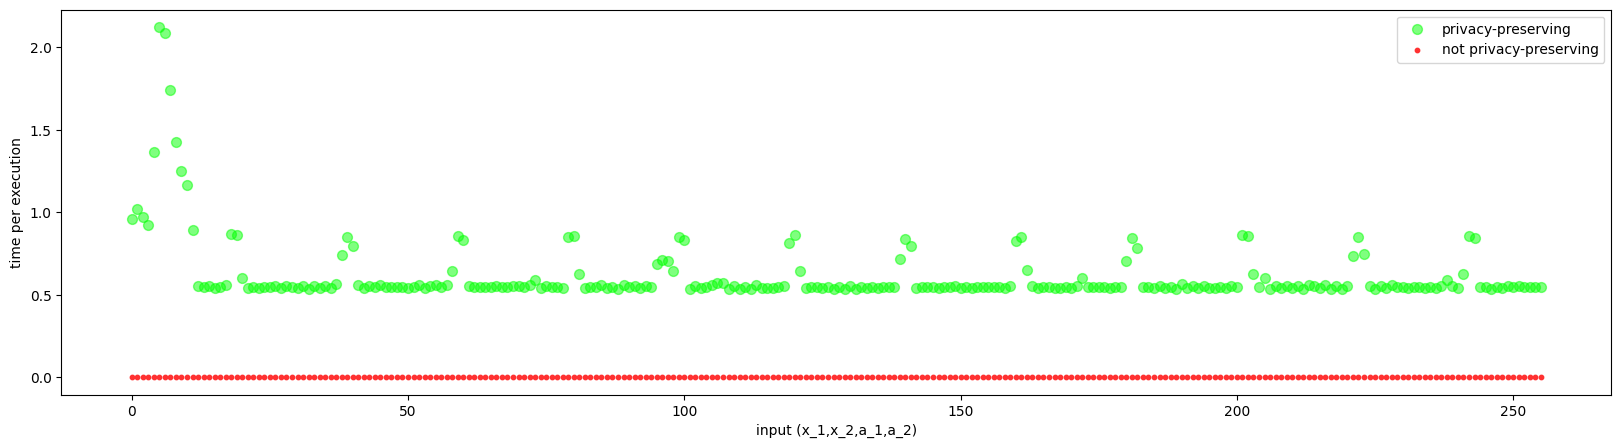

In [ ]:
plot(pp_time, npp_time)